In [1]:
import logging
import os
import re
from typing import Optional, List

import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, BatchSampler
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness
from timm import create_model
from einops import rearrange, reduce
from skimage.color import label2rgb
from skimage.measure import regionprops_table

In [2]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

###### load data

In [3]:
genes = ['EPCAM', 'IL7R', 'MS4A1', 'BGN']
predefine_genes = True

In [4]:
train_adata = sc.read_h5ad('../data/pdac/HT270P1-S1H1U1/adata.h5ad')
train_adata.X = train_adata.layers['counts'] # using raw counts
train_adata = train_adata[:, [True if v or g in genes else False
                              for v, g in zip(train_adata.var['highly_variable'], train_adata.var.index)]]
train_adata

View of AnnData object with n_obs × n_vars = 3940 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
val_adata = sc.read_h5ad('../data/pdac/HT264P1-S1H2U1/adata.h5ad')
val_adata.X = val_adata.layers['counts'] # using raw counts
val_adata = val_adata[:, train_adata.var.index]

val_adata

View of AnnData object with n_obs × n_vars = 3234 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
class HETransform(object):
    def __init__(self, p=.8, brightness=.1, contrast=.1, saturation=.1, hue=.1, sharpness=.3):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.sharpness = sharpness
        
        self.normalize = Normalize((0.771, 0.651, 0.752), (0.229, 0.288, 0.224)) # from HT397B1-H2 ffpe H&E image
 
        self.p = p
    
    def apply_color_transforms(self, x, brightness, contrast, saturation, hue, sharpness):
        x = TF.adjust_brightness(x, brightness)
        x = TF.adjust_contrast(x, contrast)
        x = TF.adjust_saturation(x, saturation)
        x = TF.adjust_hue(x, hue)
        x = TF.adjust_sharpness(x, sharpness)
        return x
        
    def __call__(self, he, mask):
        """
        """
        if isinstance(he, torch.Tensor):
            hes = [he]
            masks = [mask]
            return_type = 'image'
        elif isinstance(he, dict):
            keys = list(he.keys())
            hes = [he[k] for k in keys]
            masks = [mask[k] for k in keys]
            return_type = 'dict'
        else:
            return_type = 'list'
                                
        # we apply transforms with probability p
        if torch.rand(size=(1,)) < self.p:
            brightness, contrast, saturation, hue, sharpness = (
                np.random.uniform(max(0, 1 - self.brightness), 1 + self.brightness, size=1)[0],
                np.random.uniform(max(0, 1 - self.contrast), 1 + self.contrast, size=1)[0],
                np.random.uniform(max(0, 1 - self.saturation), 1 + self.saturation, size=1)[0],
                np.random.uniform(-self.hue, self.hue, size=1)[0],
                np.random.uniform(max(0, 1 - self.sharpness), 1 + self.sharpness, size=1)[0],
            )
            # apply color jitter and sharpness
            hes = [self.apply_color_transforms(x, brightness, contrast, saturation, hue, sharpness)
                   for x in hes]
            
            # vertical and horizontal flips happen with p=.5
            do_hflip, do_vflip = torch.rand(size=(2,)) < .5 
            if do_hflip:
                hes = [TF.hflip(x) for x in hes]
                masks = [TF.hflip(x) for x in masks]
            if do_vflip:
                hes = [TF.vflip(x) for x in hes]
                masks = [TF.vflip(x) for x in masks]
        
        # normalize he
        hes = [self.normalize(x) for x in hes]
                    
        if return_type == 'image':
            return hes[0], masks[0]
        elif return_type == 'dict':
            return {k:v for k, v in zip(keys, hes)}, {k:v for k, v in zip(keys, masks)}
        return hes, masks

In [10]:
def convert_rgb(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
        
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img)
        
    if torch.max(img)>1.1:
        img = TF.convert_image_dtype(img, dtype=torch.float32)
            
    return img


def generate_voxel_masks(labeled_mask, padded_spot_idxs, n_voxels):
    masks = torch.zeros((padded_spot_idxs.shape[0], labeled_mask.shape[0], labeled_mask.shape[1]))
    for i, l in enumerate(padded_spot_idxs[:n_voxels]):
        m = labeled_mask.clone().detach()
        m[m!=l] = 0.
        m[m==l] = 1.
        masks[i] = m
    return masks


def generate_padded_exp(adata, spot_idxs, max_spots, masks, pixels_per_voxel, use_raw=False):
    if use_raw:
        x = adata.raw.X[spot_idxs]
    else:
        x = adata.X[spot_idxs]

    if 'sparse' in str(type(x)).lower():
        x = x.toarray()

    padded_exp = torch.zeros((max_spots, x.shape[1]))
    padded_exp[:x.shape[0]] = torch.tensor(x)

    padded_exp *= (masks.sum(dim=(1,2)).unsqueeze(dim=-1) + 1.) / pixels_per_voxel
    padded_exp = torch.round(padded_exp)
    
    return padded_exp


class STDataset(Dataset):
    """ST Dataset"""
    def __init__(self, adata, he_dict, mask_dict, coordinate_key,
                 tile_sizes=512, use_raw=False, he_transform=None,
                 border=512, max_jitter=0., sample_multiplier=1):
        """
        adata: AnnData object
            - .X must be unnormalized counts
            - must have column in .obs['spot_index'] that specified the spot index in the scaled mask dict
        scaled_he_dict: dict
            - values are rgb H&E images, keys are '[0-9]+X', where the integer in front of X is the scale factor of the H&E image.
        scaled_mask_dict: dict
            - values are labeled images where 0 is background and all other pixels coorespond to index stored in .obs['spot_index'].
        """
        super().__init__()
        # make sure we are ordered by spot index
        self.spot_ids, _ = zip(*sorted([(sid, sidx) for sid, sidx in zip(adata.obs.index, adata.obs['spot_index'])],
                                    key=lambda x: x[1]))
        self.spot_ids = np.asarray(self.spot_ids)
        self.adata = adata[self.spot_ids]
        self.he_dict = {k:convert_rgb(v) for k, v in he_dict.items()}
        self.mask_dict = {k:torch.tensor(v).to(torch.int32) if not isinstance(v, torch.Tensor) else v
                                 for k, v in mask_dict.items()}
        self.scales = sorted([int(re.sub(r'^([0-9]+)X$', r'\1', k)) for k in self.he_dict.keys()])
        
        if isinstance(tile_sizes, int):
            self.tile_sizes = [tile_sizes] * len(self.scales)
        else:
            self.tile_sizes = tile_sizes # defines the size of crops to be taken from each h&e resolution
        
        _, n_row, n_col = self.he_dict[str(self.scales[0]) + 'X'].shape
        self.offset = int(self.tile_sizes[0] // 2 + 1)
        self.border = border
  
        self.pixel_coords = np.asarray(
            [[int(r + np.random.uniform(-max_jitter, max_jitter)),
              int(c + np.random.uniform(-max_jitter, max_jitter))]
             for c, r in self.adata.obsm[coordinate_key]])
        if sample_multiplier > 1:
            for i in range(sample_multiplier - 1):
                self.pixel_coords = np.concatenate(
                    (self.pixel_coords,
                     np.asarray(
                        [[int(r + np.random.uniform(-max_jitter, max_jitter)),
                          int(c + np.random.uniform(-max_jitter, max_jitter))]
                         for c, r in self.adata.obsm[coordinate_key]])), axis=0)
        
        self.he_transform = he_transform
        
        
        # expression related
        self.use_raw = use_raw
        
        idxs = np.random.choice(np.arange(self.pixel_coords.shape[0]), size=1000)
        key = str(self.scales[0]) + 'X'
        max_spots = 0
        self.pixels_per_voxel = 0
        for i in idxs:
            mask = self.mask_dict[key]
            r, c = self.pixel_coords[i]
            r, c = r + self.border, c + self.border # adjust for reflection padding
            r, c = r - self.offset, c - self.offset # adjust from center to top left
            m = TF.crop(mask, top=r, left=c, height=self.tile_sizes[0], width=self.tile_sizes[0])
            max_spots = max(max_spots, len(np.unique(m)))
        self.max_spots = 2**int(np.log2(max_spots) + 1)
        
        r, c = n_row // 2, n_col // 2
        tile = self.mask_dict[key][r:r + self.tile_sizes[0] * 2, c:c + self.tile_sizes[0] * 2]
        self.pixels_per_voxel = np.max(
            regionprops_table(tile.detach().numpy(), properties=['label', 'area'])['area'])
        
    
    def get_item_dict(self, idx, apply_transform=True):
        r, c = self.pixel_coords[idx]
        initial = self.scales[0]
        scale_to_coords = {s: (
                               int((r / (s / initial)) - self.offset + self.border),
                               int((c / (s / initial)) - self.offset + self.border)
                           )
                           for i, s in enumerate(self.scales)}
        he_tile_dict, mask_tile_dict = {}, {}
        for scale, tile_size in zip(self.scales, self.tile_sizes):
            key = f'{scale}X'
            he, mask = self.he_dict[key], self.mask_dict[key]
            r, c = scale_to_coords[scale]
            he_tile_dict[key] = TF.crop(he, top=r, left=c, height=tile_size, width=tile_size)
            mask_tile_dict[key] = TF.crop(mask, top=r, left=c, height=tile_size, width=tile_size)
        if self.he_transform is not None and apply_transform:
            he_tile_dict, mask_tile_dict = self.he_transform(he_tile_dict, mask_tile_dict)
        spot_idxs = torch.unique(mask_tile_dict[str(self.scales[0]) + 'X']).numpy() - 1
        spot_idxs = spot_idxs[1:] # drop first value, which is background
        padded_spot_idxs = np.asarray([0] * self.max_spots)
        padded_spot_idxs[:spot_idxs.shape[0]] = spot_idxs + 1
        masks = generate_voxel_masks(mask_tile_dict[str(self.scales[0]) + 'X'],
                                     padded_spot_idxs, len(spot_idxs))
        padded_exp = generate_padded_exp(self.adata, spot_idxs, self.max_spots,
                                         masks, self.pixels_per_voxel, use_raw=self.use_raw)
                
        return {
            'X': padded_exp,
            'he_tiles': he_tile_dict,
            'mask_tiles': mask_tile_dict,
            'voxel_idxs': padded_spot_idxs,
            'masks': masks,
            'n_voxels': len(spot_idxs),
            'b': torch.tensor([1.]), # just make everything the same batch for now
            'voxel_idx': idx,
        }

    def __len__(self):
        return len(self.pixel_coords)

    def __getitem__(self, idx):
        return self.get_item_dict(idx)
    
    
class ValSTDataset(STDataset):
    def __init__(self, adata, he_dict, mask_dict, coordinate_key, idx_pool=None,
                 tile_sizes=512, use_raw=False, he_transform=None,
                 border=512, max_jitter=0., sample_multiplier=1,
                 include_no_transform=True):
        super().__init__(adata, he_dict, mask_dict, coordinate_key,
                 tile_sizes=tile_sizes, use_raw=use_raw, he_transform=he_transform,
                 border=border, max_jitter=max_jitter, sample_multiplier=sample_multiplier)
        if idx_pool is not None:
            self.pixel_coords = self.pixel_coords[np.asarray(idx_pool)]
        
    
    def __getitem__(self, idx):
        to_return = self.get_item_dict(idx)
        no_transform = self.get_item_dict(idx, apply_transform=False)
        to_return['he_tiles_orig'] = no_transform['he_tiles']
        return to_return
        
        

In [11]:
def reflection_mosiac(x, border=256, dtype=torch.int32):
    max_r, max_c = x.shape[-2], x.shape[-1]
    if len(x.shape) == 3:
        mosaic = torch.zeros((x.shape[0], max_r + (border * 2), max_c + (border * 2))).to(dtype)
    else:
        mosaic = torch.zeros((max_r + (border * 2), max_c + (border * 2))).to(dtype)
    
    # make tiles
    top_left = TF.pad(x, padding=[border, border, 0, 0], padding_mode='reflect')
    top_right = TF.pad(x, padding=[0, border, border, 0], padding_mode='reflect')
    bottom_left = TF.pad(x, padding=[border, 0, 0, border], padding_mode='reflect')
    bottom_right = TF.pad(x, padding=[0, 0, border, border], padding_mode='reflect')
    
    if len(x.shape) == 3:
        mosaic[:, :max_r + border, :max_c + border] = top_left
        mosaic[:, :max_r + border, border:] = top_right
        mosaic[:, border:, :max_c + border] = bottom_left
        mosaic[:, border:, border:] = bottom_right
    else:
        mosaic[:max_r + border, :max_c + border] = top_left
        mosaic[:max_r + border, border:] = top_right
        mosaic[border:, :max_c + border] = bottom_left
        mosaic[border:, border:] = bottom_right
    
    return mosaic

In [12]:
def get_img_dicts(adata, keys=('2X', '8X'), border=256):
    he_dict = {}
    for k, x in adata.uns['rescaled_he'].items():
        if re.findall(r'^[0-9]+X.*$', k) and 'trimmed' in k:
            scale = int(re.sub(r'^([0-9]+)X.*$', r'\1', k))
            x = torch.tensor(rearrange(x, 'h w c -> c h w')).to(torch.uint8)
            x = reflection_mosiac(x, border=border, dtype=torch.uint8)
            x = rearrange(x, 'c h w -> h w c').numpy().astype(np.uint8)
            he_dict[f'{scale}X'] = x
            
    mask_dict = {}
    for k, x in adata.uns['rescaled_spot_masks'].items():
        if re.findall(r'^[0-9]+X.*$', k) and 'trimmed' in k:
            scale = int(re.sub(r'^([0-9]+)X.*$', r'\1', k))
            x = torch.tensor(x.astype(np.int32))
            x = reflection_mosiac(x, border=border, dtype=torch.int32)
            x = x.numpy().astype(np.int32)
            mask_dict[f'{scale}X'] = x
            
    he_dict = {k:v for k, v in he_dict.items() if k in keys}
    mask_dict = {k:v for k, v in mask_dict.items() if k in keys}
    
    return he_dict, mask_dict

In [13]:
# keys = ['2X', '8X']
# tile_size = 256
# spot_radius = train_adata.uns['rescaled_spot_metadata'][keys[0] + '_trimmed']['spot_radius']
# jitter = spot_radius * 2
# border = jitter * 2

# he_dict, mask_dict = get_img_dicts(train_adata, keys=keys, border=border)

# train_he_transform = HETransform(p=.8, brightness=.05, contrast=.05, saturation=.05, hue=.05)
# train_ds = STDataset(train_adata, he_dict, mask_dict, 'spatial_2X_trimmed',
#                      tile_sizes=tile_size, he_transform=train_he_transform,
#                      max_jitter=jitter, border=border, sample_multiplier=100)

In [70]:
keys = ['2X', '8X']
tile_size = 256
spot_radius = train_adata.uns['rescaled_spot_metadata'][keys[0] + '_trimmed']['spot_radius']
# jitter = spot_radius * 2
# border = jitter * 2
border = spot_radius * 4

he_dict, mask_dict = get_img_dicts(train_adata, keys=keys, border=border)

train_he_transform = HETransform(p=.95, brightness=.1, contrast=.1, saturation=.1, hue=.1)
train_ds = ValSTDataset(train_adata, he_dict, mask_dict, 'spatial_2X_trimmed',
                     tile_sizes=tile_size, he_transform=train_he_transform,
                     max_jitter=0., border=border, sample_multiplier=10)

In [71]:
he_dict, mask_dict = get_img_dicts(val_adata, keys=keys, border=border)
# pool = [724, 800, 397, 1011, 1022, 2011]
val_he_transform = HETransform(p=0.0)
val_ds = ValSTDataset(val_adata, he_dict, mask_dict, 'spatial_2X_trimmed',
                   tile_sizes=tile_size, he_transform=val_he_transform,
                   max_jitter=0., border=border, sample_multiplier=1)

In [72]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [76]:
exp

tensor([[16.,  0.,  1.,  ...,  2.,  0.,  0.],
        [ 2.,  0.,  2.,  ...,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  ...,  1.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [ ]:
d = train_ds[100]
he, he_orig, masks, voxel_idxs, exp = d['he_tiles']['2X'], d['he_tiles_orig']['2X'], d['masks'], d['voxel_idxs'], d['X']

he = torch.zeros(len(train_ds), 3, tile_size, tile_size)
he_orig = torch.zeros(len(train_ds), 3, tile_size, tile_size)
masks = torch.full((len(train_ds), masks.shape[0], masks.shape[1], masks.shape[2]), 0, dtype=torch.bool)
voxel_idxs = torch.zeros(len(train_ds), voxel_idxs.shape[0], dtype=torch.int16)
exp = torch.zeros(len(train_ds), exp.shape[0], exp.shape[1])

for i in range(len(train_ds)):
    d = train_ds[i]
    he[i] = d['he_tiles']['2X']
    
    

###### check tiles

In [30]:
batch = next(iter(train_dl))
x, b, masks, voxel_idxs, exp = batch['he_tiles']['2X'], batch['b'], batch['masks'], batch['voxel_idxs'], batch['X']

In [66]:
d = train_ds[100]
x, b, masks, voxel_idxs, exp = d['he_tiles']['2X'], d['b'], d['masks'], d['voxel_idxs'], d['X']

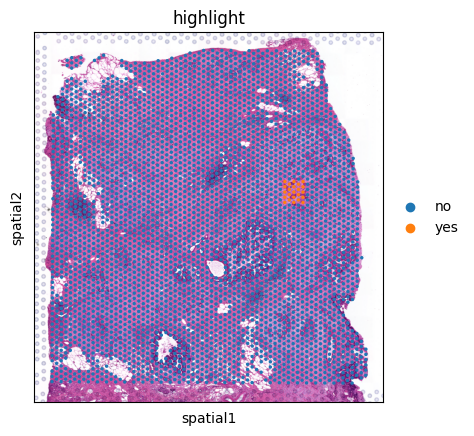

In [68]:
train_adata.obs['highlight'] = ['yes' if i in d['voxel_idxs'][:d['n_voxels']] else 'no'
                               for i in train_adata.obs['spot_index']]
sc.pl.spatial(train_adata, color='highlight')

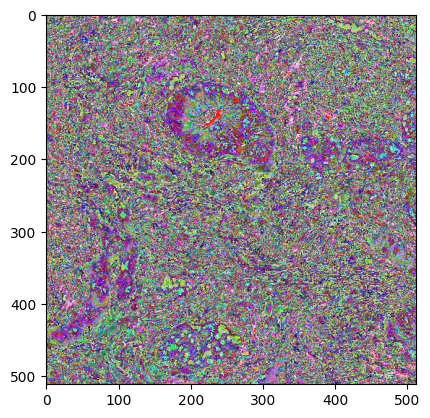

In [69]:
tile = rearrange(TF.convert_image_dtype(d['he_tiles']['2X'], torch.uint8), 'c h w -> h w c')
plt.imshow(tile)

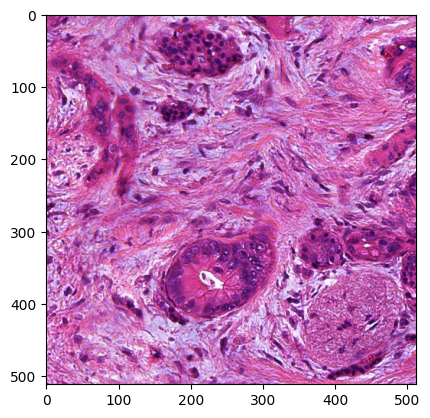

In [46]:
tile = rearrange(TF.convert_image_dtype(d['he_tiles_orig']['2X'], torch.uint8), 'c h w -> h w c')
plt.imshow(tile)

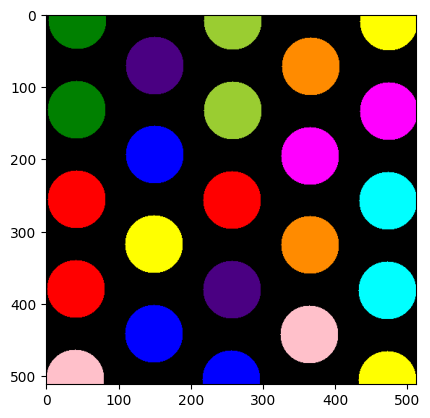

In [47]:
tile = label2rgb(d['mask_tiles']['2X'].numpy())
plt.imshow(tile)

In [48]:
def construct_tile_expression(padded_exp, masks, n_voxels):
    tile = torch.zeros((masks.shape[1], masks.shape[2], padded_exp.shape[1]))
    for exp, m in list(zip(padded_exp, masks))[:n_voxels]:
        tile[m==1] = exp
    return tile

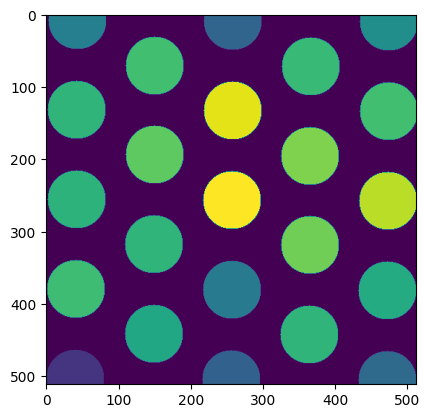

In [55]:
recon = construct_tile_expression(d['X'], d['masks'], d['n_voxels'])
plt.imshow(recon[:, :, 1995])

In [54]:
train_adata.var.index.to_list().index('BGN')

1995

In [ ]:
he_dict, mask_dict = get_img_dicts(val_adata, keys=keys, border=border)
pool = [724, 800, 397, 1011, 1022, 2011]
val_he_transform = HETransform(p=0.)
val_ds = ValSTDataset(val_adata, he_dict, mask_dict, 'spatial_2X_trimmed',
                   tile_sizes=tile_size, he_transform=val_he_transform,
                   max_jitter=0., border=border, sample_multiplier=1, idx_pool=pool)